# Sampling in MRI

## Introduction

![Sampling in MRI](../imgs/sampling_in_MRI.png)

Perfect reconstruction of an object would require measurement of all locations in k-space (infinite!).

**Low frequencies = Contrast**

![low_freq](../imgs/low_freq.png)

**High frequencies = boundaries/edges**

![high_freq](../imgs/high_freq.png)

The highest frequency $k^{max}$ determines image reoslution, and the larger the $k^{max}$ is, the higher the resolution we can get.

![k-resolution](../imgs/k_resolution.png)

The field of view is the reciprocal of $\triangle k_x$, which is also equal to $x_{max}$, and $\triangle x = \frac{1}{2k^{max}_x}$. k-space and image resolution are inversely related: resolution in one domain determines extent in other.

![delta_k_comp](../imgs/delta_k_comp.png)

### Background in MR Acquisition

- TR: Time between 2 successive RF pulse
- TE: time point associated with the center of echo: $k_x(\mathrm{TE})=0$

![comp_models](../imgs/comp_models.png)

- $T_1$-w: Short TE, TR → short readout and thus straight lines (Cartesian or radial) are unavoidable
- $T_2, T_2^*$-w: long TE, TR → enable long readout → more fancy trajectories are feasible

### Cartesian vs non-Cartesian trajectories

- Cartesian: easier to implement but less prone to gradient errors, play one gradient at a time
- Non-cartesian: robust to motion, more flexible and efficient sampling but prone to gradient errors

### Single Shot vs Multi-shot

- Multiple shot = longer acquisition time, better image quality
- Single shot = faster acquisition, e.g. for dynamic MR imaging mainly


## Basic deterministic under-sampling

We want to generate a sampling mask $\Omega \in \{0, 1\}^N$ such that $y = F_\Omega x$ where $x \in R^N$ in the original image. The data $y$ is then corrupted by additive noise $b$:

$$
y = F_\Omega x + b
$$

where $b$ is a complex-valued circular Gaussian noise of variance $\sigma^2$ and $F_\Omega=\Omega F$ in this **Cartesian** setting (i.e. sampling on the grid).

We consider:

1. a low-frequency Cartesian mask $\Omega$ is defined by *the central lines* of k-space
2. a low-frequency Cartesian mask $\Omega$ is defined by *a square box* in k-space centered at $(k_x, k_y) = (0,0)$
3. a high-frequency Cartesian mask $\Omega$ is defined as the complementary set of the lines defined in to 1)
4. a high-frequency Cartesian mask $\Omega$ is defined as the complementary set of the box defined in 2)

Based on these masks we generate the correspond measured data from a reference MR image and finally perform Cartesian image reconstruction $\hat x$ from the under-sampled data $y$ as follows:

$$
\hat x = F^* y
$$

where $F^*$ is the zero-filled inverse Fourier transform (ifft).

We first read an "original image" of MRI with a 2D dimension of $512 \times 512$, and then add some noise to it to simulate the real scenario.



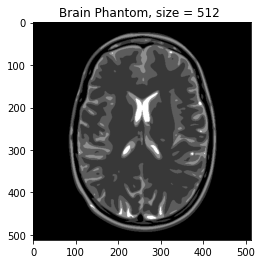

In [1]:
## Display Brain Phantom
%matplotlib inline
import os
import os.path as op
import math

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io

dirimg_2d = "./data/"
img_size = 512 # also 256
FOV = 0.2 # Field of view in m
pixelSize = FOV/ img_size

# load data file corresponding to the target resolution
filename = "BrainPhantom%s.png" % img_size
mri_filename = dirimg_2d + filename
mri_img = io.imread(mri_filename)

# plotting
plt.figure()
plt.title("Brain Phantom, size = %s " % img_size)
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

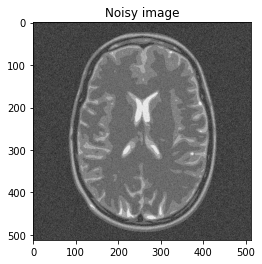

In [2]:
# add noise to image
noise_img = np.copy(mri_img.astype('float64'))
noise_img += np.random.randn(*mri_img.shape) * 20.

plt.figure()
plt.imshow(noise_img, cmap='Greys_r')
plt.title("Noisy image")
plt.savefig("./data/noisy_brain.png")
plt.show()

After that, the object is to construct a low-frequency sampling mask that consists of the central k-space lines. We implement Fourier transform the reference MR image to compute k-space data, add zero-mean Gaussian complex-valued noise. And then, we mask the data using the above defined mask. Next, we perform a zero-filled MR image reonstruction from masked k-space data.

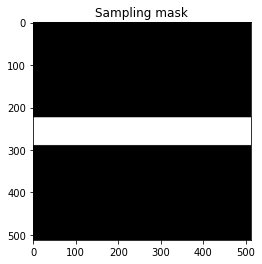

In [3]:
# Generate trivial Cartesian sampling masks
## img_size = 512

mask = "low_res"
factor_ctr = 8

# Construct a k-space mask that consists of the central lines
## 0 entries: points not sampled; 1 entries: points to be sampled
## Initialize k-space with 0 everywhere and then place the "1" appropriately.

kspace_masklines = np.zeros((img_size, img_size), dtype="float64") # a zero-filled mask
low_res_size = img_size // factor_ctr + 1 # calculate the sampling area width, a total of 65 entries 
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size) # get all entries in this interval
idx_vec_ = idx_vec.astype("int") # Get the serial number of each entry
kspace_masklines[idx_vec_, ] = 1 # Turn these entries to 1

# Show the mask
plt.figure()
plt.imshow(kspace_masklines, cmap="Greys_r")
plt.title("Sampling mask")
plt.show()

In [4]:
# Define Fourier and Inverse Fourier Transform

norm = "ortho"

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

The overall pipeline of what we do next is as followed:
![](../imgs/x-k-flow.png)

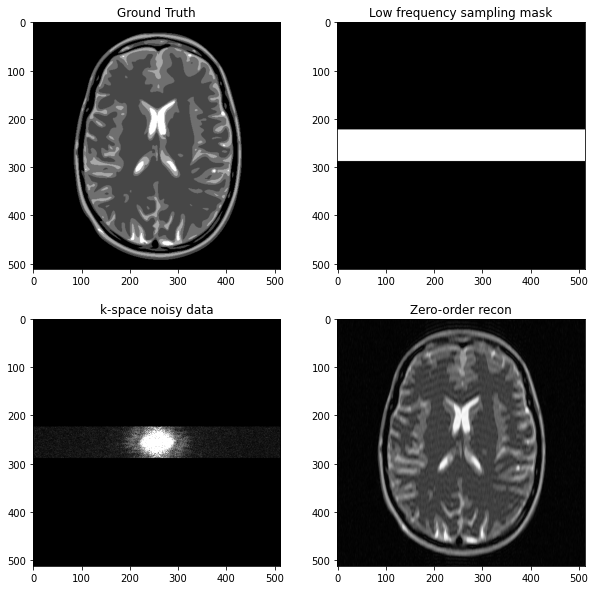

In [5]:
# Generate the kspace data
## First we Fourier transform the image 
kspace_data = np.fft.fftshift(fft(mri_img))
## add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)

## Mask data to perform subsampling
kspace_data *= kspace_masklines

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

# imshow
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap="Greys_r")
axs[0, 0].set_title("Ground Truth")
axs[0, 1].imshow(kspace_masklines, cmap="Greys_r")
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data), cmap='Greys_r', vmax=0.01 * np.abs(kspace_data).max()) # scale up the noise
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap="Greys_r")
axs[1, 1].set_title("Zero-order recon")

plt.show()

Based on the previous example, try to construct a low-frequency sampling mask defined by **a square box** centered around $(k_x, k_y)=(0, 0)$

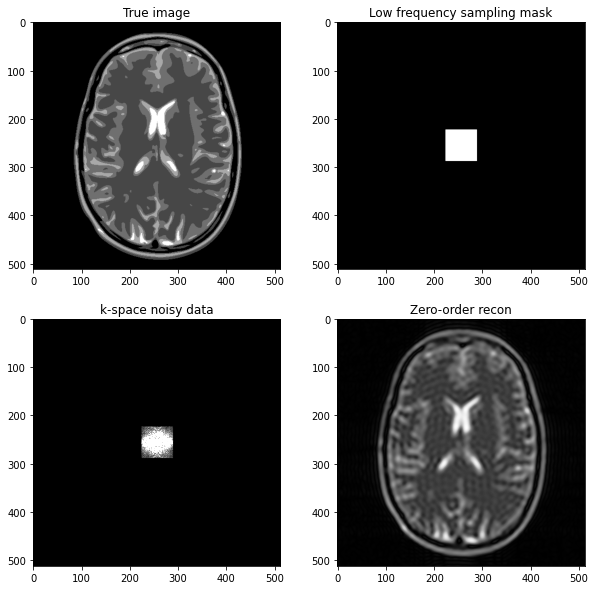

In [6]:
# Construct a k-space mask consisting of a central box
## Initalize k-space with 0
kspace_maskbox = np.zeros((img_size, img_size), dtype="float64")
# fill the rectangle with 1
kspace_maskbox[idx_vec_, ] = 1

## Get the whole list [0, ..., 511]
list_img_size = np.arange(0., img_size).tolist()
## filter the [223, ..., 287]
filtered_center = [x for x in list_img_size if x not in idx_vec_]
## set the filtered array to 0, the other is 1 
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")
kspace_maskbox[:, array_idx_center_] = 0

# fft -> fftshift -> add noise and apply mask -> ifftshift -> ifft
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_maskbox

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_maskbox, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

Next is to construct a k-space sampling mask that consists of the high-frquency lines, without the central lines. Let's see how it would be.

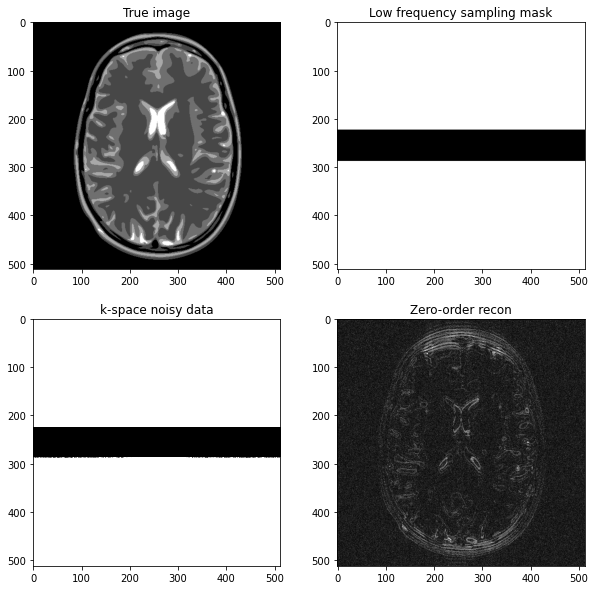

In [7]:
# Generate trivial Cartesian sampling masks
## img_size = 512

mask = "low_res"
factor_ctr = 8

# Construct a k-space mask that consists of the central lines
## 0 entries: points not sampled; 1 entries: points to be sampled
## Initialize k-space with 0 everywhere and then place the "1" appropriately.

kspace_masklines = np.ones((img_size, img_size), dtype="float64") # a zero-filled mask
low_res_size = img_size // factor_ctr + 1 # calculate the sampling area width, a total of 65 entries 
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size) # get all entries in this interval
idx_vec_ = idx_vec.astype("int") # Get the serial number of each entry
kspace_masklines[idx_vec_, ] = 0 # Turn these entries to 1

# fft -> fftshift -> add noise and apply mask -> ifftshift -> ifft
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_masklines

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_masklines, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()


Based on the previous examples, try to construct a k-space mask that consists of the removing the central box centered in $(k_x, k_y)=(0, 0)$.

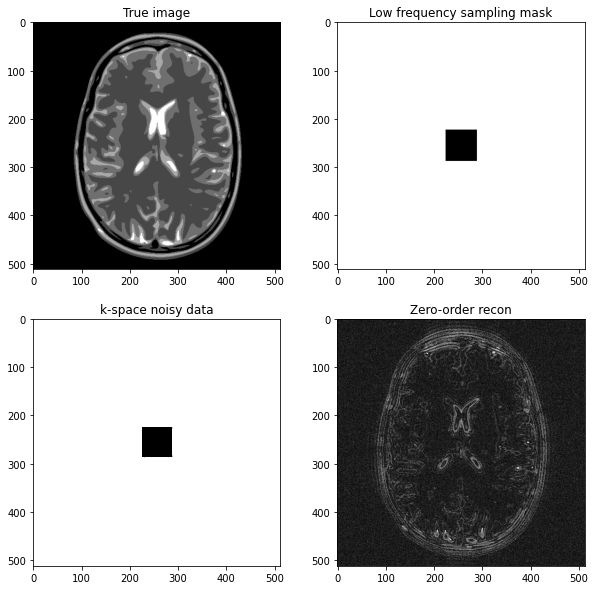

In [8]:
# Construct a k-space mask consisting of a central box
## Initalize k-space with 0
kspace_maskbox = np.ones((img_size, img_size), dtype="float64")
# fill the rectangle with 1
kspace_maskbox[idx_vec_, ] = 0

## Get the whole list [0, ..., 511]
list_img_size = np.arange(0., img_size).tolist()
## filter the [223, ..., 287]
filtered_center = [x for x in list_img_size if x not in idx_vec_]
## set the filtered array to 0, the other is 1 
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")
kspace_maskbox[:, array_idx_center_] = 1

# fft -> fftshift -> add noise and apply mask -> ifftshift -> ifft
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_maskbox

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_maskbox, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

Now we can compare the differences among all these reconstructed images. Let's summarise the code here:

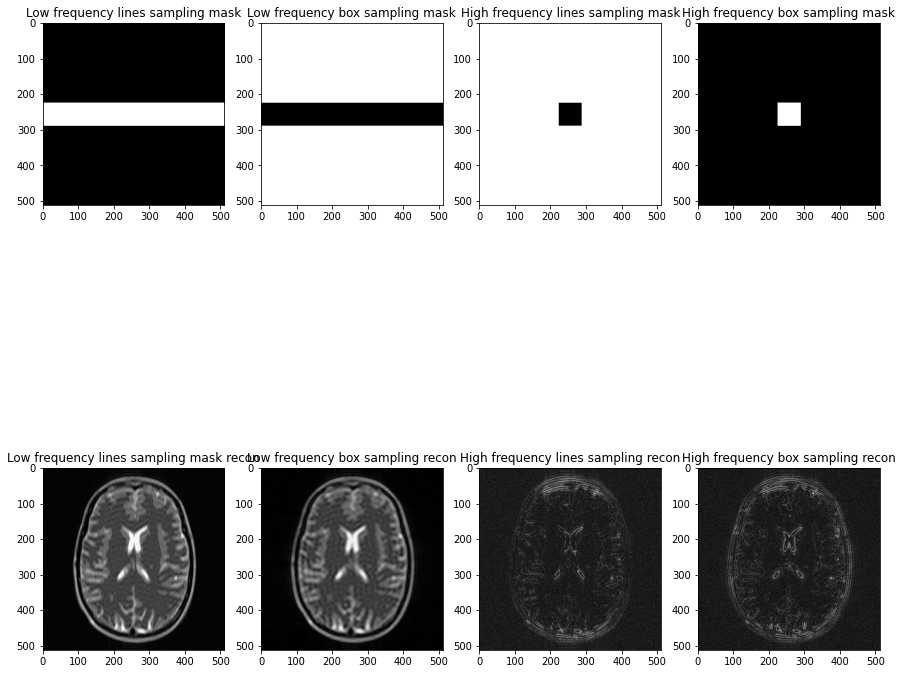

In [9]:
# We have the original image `x`
img_size = 512 # also 256
FOV = 0.2 # Field of view in m
pixelSize = FOV/ img_size
filename = "BrainPhantom%s.png" % img_size
mri_filename = './data/' + filename
mri_img = io.imread(mri_filename)

# Then we construct the mask
factor_ctr = 8
mask_low_lines = np.zeros((img_size, img_size), dtype="float64")
low_res_size = img_size // factor_ctr + 1
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size)
idx_vec_ = idx_vec.astype("int")

## low_freq_lines
mask_low_lines[idx_vec_, ] = 1
## high-freq-lines
mask_high_lines = 1 - mask_low_lines
mask_high_lines_bak = np.copy(mask_high_lines)

list_img_size = np.arange(0., img_size).tolist()
filtered_ceter = [x for x in list_img_size if x not in idx_vec_]
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")

## high_freq_box
mask_high_lines[:, array_idx_center_]=1
mask_high_box = mask_high_lines
mask_high_lines = mask_high_lines_bak
## low_freq_box
mask_low_box = 1 - mask_high_box

# Implement Fourier Transform
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)

# Get the reconstructed result
recon_low_freq_lines = ifft(np.fft.ifftshift(kspace_data * mask_low_lines))
recon_low_freq_box = ifft(np.fft.ifftshift(kspace_data * mask_low_box))
recon_high_freq_lines = ifft(np.fft.ifftshift(kspace_data * mask_high_lines))
recon_high_freq_box = ifft(np.fft.ifftshift(kspace_data * mask_high_box))

# Plotting
fig, axs = plt.subplots(2, 4, figsize=(15, 15))
## 4 masks
axs[0, 0].imshow(mask_low_lines, cmap='Greys_r')
axs[0, 0].set_title("Low frequency lines sampling mask")
axs[0, 1].imshow(mask_high_lines, cmap='Greys_r')
axs[0, 1].set_title("Low frequency box sampling mask")
axs[0, 2].imshow(mask_high_box, cmap='Greys_r')
axs[0, 2].set_title("High frequency lines sampling mask")
axs[0, 3].imshow(mask_low_box, cmap='Greys_r')
axs[0, 3].set_title("High frequency box sampling mask")

axs[1, 0].imshow(np.abs(recon_low_freq_lines), cmap='Greys_r')
axs[1, 0].set_title("Low frequency lines sampling mask recon")
axs[1, 1].imshow(np.abs(recon_low_freq_box), cmap='Greys_r')
axs[1, 1].set_title("Low frequency box sampling recon")
axs[1, 2].imshow(np.abs(recon_high_freq_lines), cmap='Greys_r')
axs[1, 2].set_title("High frequency lines sampling recon")
axs[1, 3].imshow(np.abs(recon_high_freq_box), cmap='Greys_r')
axs[1, 3].set_title("High frequency box sampling recon")
plt.show()


We can see that, the low frequency part occupies the dominant part of the information in k-space, especially in the center box area. And the more you sampled, the more you can reconstructed (in zero-filled method).

## iid Variable Density Sampling

Here is to demonstrate the interest of using *iid variable density sampling*. The theory **optimal distributions** from the CS theory on orthonormal systems for Shannon wavelets or from handcrafted densities parameterized by the decay $\eta$:

$$
p(k_x, k_y)=1/(k^2_x + k^2_y)^{\eta/2}, \eta \simeq 3
$$

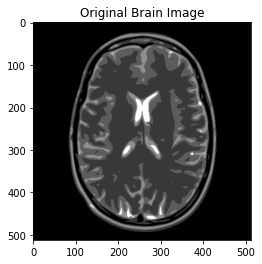

In [10]:
%matplotlib inline

import math, cmath, sys
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, filters

dirimg_2d = './data/'
img_size = 512
FOV = 0.2 # field of view
pixelSize = FOV/img_size

# Load image file corresponding to the target resolution
filename = "BrainPhantom%s.png" % img_size
mri_filename = dirimg_2d + filename
mri_img = io.imread(mri_filename)

plt.figure()
plt.title("Brain Phantom, size= " + str(img_size))

if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
    
plt.title("Original Brain Image")
plt.show()

Text(0.5, 1.0, 'Variable density sampling mask')

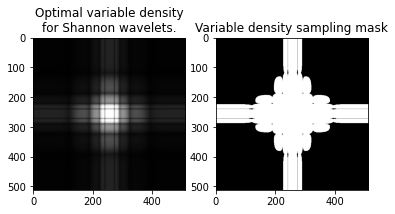

In [11]:
from scipy.io import loadmat

# load target sampling distribution, which is precalculated in Matlab
densities = loadmat(dirimg_2d + "2d_sampling_densities.mat")

if img_size == 512:
    ## generated using orthogonal Symmlet10 wavelet transform for img size 512x512
    opt_density = densities['distrib2d_N512_sym10']
else:
    ## generated using orthogonal Symmlet10 wavelet transform for img size 256x256
    opt_density = densities['distrib2d_N256_sym10']  
    
# Generate Cartesian variable density mask
threshold = 10. * opt_density.min()
kspace_mask = np.where(opt_density > threshold, 1, np.zeros((img_size, img_size), dtype="float64"))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(opt_density, cmap='Greys_r')
axs[0].set_title("Optimal variable density\nfor Shannon wavelets.")
axs[1].imshow(kspace_mask, cmap='Greys_r')
axs[1].set_title("Variable density sampling mask")    

In [12]:
norm = "ortho"

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

def fftshift(x):
    return np.fft.fftshift(x)

def ifftshift(x):
    return np.fft.ifftshift(x)

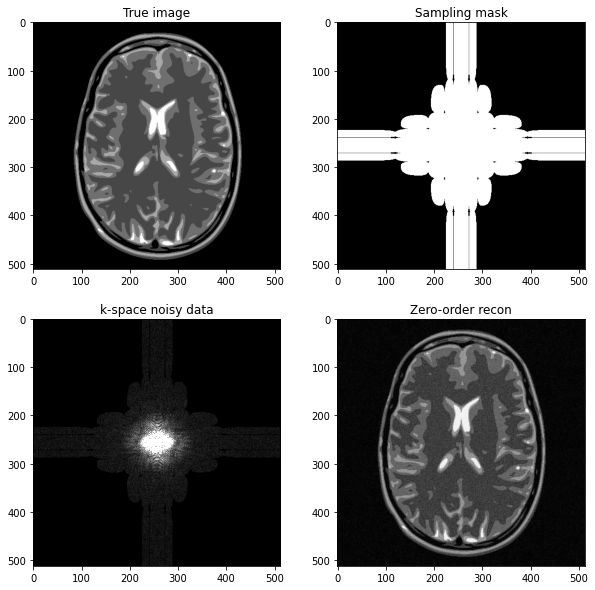

In [13]:
# Generate the kspace data
kspace_data = fftshift(fft(mri_img))
# add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask

# zero order solution
img_rec0 = ifft(ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask, cmap='Greys_r')
axs[0, 1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
# axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

Now we construct by hands a variable sampling distribution. You can change the decay to modify the decreasing behavior in the center of k-space. The larger the decay, the faster the decrease from low to high-frequencies.

In [14]:
def decayed_mask(decay, img_size, opt_density):
    
    x = np.linspace(-1. / (2. * np.pi), 1. / (2. * np.pi), img_size)
    X, Y = np.meshgrid(x, x)
    r = np.sqrt(X ** 2 + Y ** 2)

    p_decay = np.power(r,-decay)
    p_decay = p_decay/np.sum(p_decay)
    
    # change the value below if you want to change the final subsampling mask
    threshold = 2 * opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
    kspace_mask = np.zeros((img_size,img_size), dtype="float64")
    kspace_mask = np.where(p_decay > threshold, 1, kspace_mask)
    
    return p_decay, kspace_mask

Text(0.5, 1.0, 'VD sampling mask decay=2')

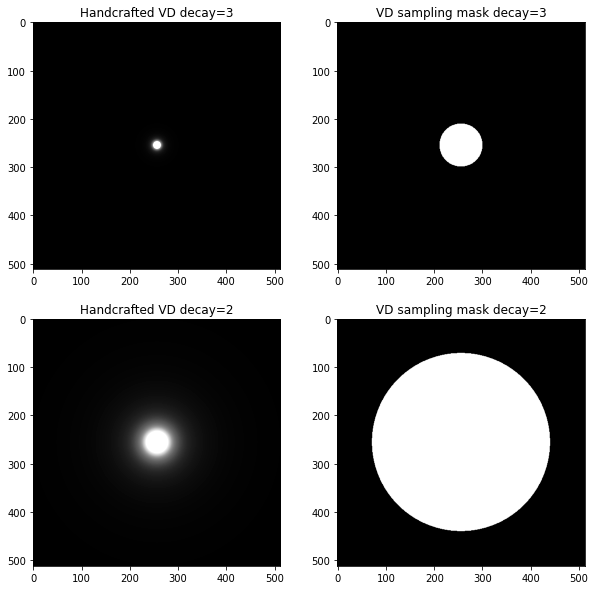

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(decayed_mask(3, img_size, opt_density)[0], cmap='Greys_r', vmax=0.001 * np.abs(decayed_mask(3, img_size, opt_density)[0]).max())
axs[0, 0].set_title("Handcrafted VD decay=3")
axs[0, 1].imshow(decayed_mask(3, img_size, opt_density)[1], cmap='Greys_r') 
axs[0, 1].set_title("VD sampling mask decay=3")
axs[1, 0].imshow(decayed_mask(2, img_size, opt_density)[0], cmap='Greys_r', vmax=0.001 * np.abs(decayed_mask(2, img_size, opt_density)[0]).max())
axs[1, 0].set_title("Handcrafted VD decay=2")
axs[1, 1].imshow(decayed_mask(2, img_size, opt_density)[1], cmap='Greys_r') 
axs[1, 1].set_title("VD sampling mask decay=2")


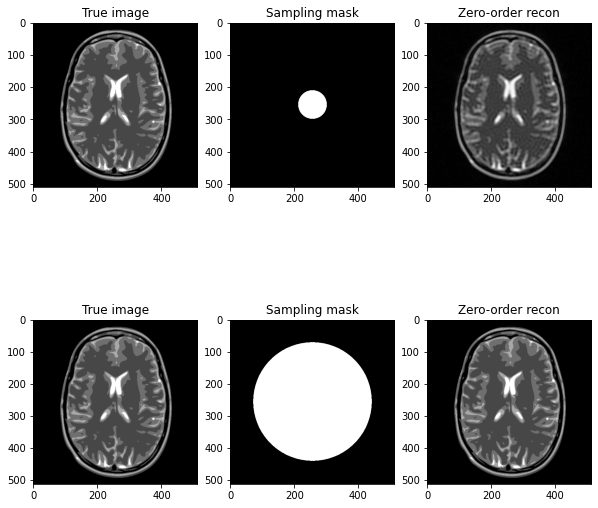

In [16]:
# Generate the kspace data: first Fourier transform the image
kspace_data = fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data_bak = kspace_data.copy()

fig, axs = plt.subplots(2, 3, figsize=(10, 10))

kspace_mask = decayed_mask(3, img_size, opt_density)[1]
kspace_data *= kspace_mask
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask, cmap='Greys_r')
axs[0, 1].set_title("Sampling mask")
axs[0, 2].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[0, 2].set_title("Zero-order recon")
axs[1, 0].imshow(mri_img, cmap='Greys_r')
axs[1, 0].set_title("True image")
kspace_mask = decayed_mask(2, img_size, opt_density)[1]
kspace_data = kspace_mask * kspace_data_bak
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))
axs[1, 1].imshow(kspace_mask, cmap='Greys_r')
axs[1, 1].set_title("Sampling mask")
axs[1, 2].set_title("Zero-order recon")
axs[1, 2].imshow(mri_img, cmap='Greys_r')
plt.show()

## 1D Cartesian Structured VDS along Parallel Lines

We will perform pseudo-random variable density sampling along the phase encoding direction. A handcrafted density is designed and samples are then drawn by virtually inverting its cumulative density function. Then these samples define the selected phase encoding lines retained in the sampling mask. Low frequencies are more sampled than higher frequencies.

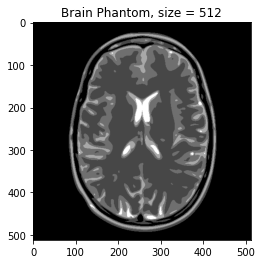

In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, filters

dirimg_2d = './data/'
img_size = 512
FOV = 0.2
pixelSize = FOV / img_size

filename = "BrainPhantom%s.png"%img_size
mri_img = io.imread(dirimg_2d + filename)
plt.figure()
plt.title("Brain Phantom, size = %s"%img_size)
plt.imshow(mri_img, cmap="Greys_r")

<Figure size 432x288 with 0 Axes>

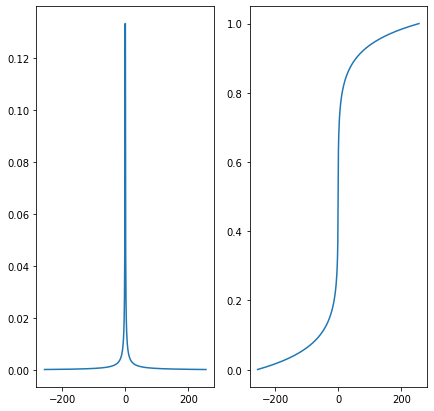

In [18]:
import numpy as np
import sys

# Get a small number
eps = sys.float_info.epsilon
# Generate a 1 * 512 one vector
c = np.ones((1, img_size), dtype="float64")
# Generate 512 * 512 kspace mask
kspace_mask = np.tile(c, (img_size, 1))
# linspace from -256 to 256
kspace_lines = np.linspace(-1/2, 1/2, img_size) * img_size
# define the target sampling density
decay = 1
# Get the reciprocals and normalize them
p_decay = np.power(np.abs(kspace_lines), -decay)
p_decay = p_decay / np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)

pmax = p_decay.max()
pmin = p_decay.min()

# Plot the density and its cumulative distribution function (CDF) p_decay
plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].plot(kspace_lines, p_decay)
axs[1].plot(kspace_lines, cdf_pdecay)



[288 255 256 250 255 489 255 249 245 268 501 255 237 256 275 261 243 355
 282 288 255 215 264 247 252 260 255 255 230 184 255 328 167 255 256 270
 251 251 256 255 229 169 255 255 262 252 255 249 328 422 250 284  94 215
 257 253 231 250 258 255 253 259 261 300 271 254 256 253 265 224 256 263
 255 258 254 255 255 258 255 255 233  66 271 243 256  16 252 259 260 347
 255 245 230 270 246 281 297 254 202 256 283 256 285 259 255 261 250 257
 255 269 255 255 224 252 191 251 292 266 363 255 257 274 214 130 257 254
 278 255]


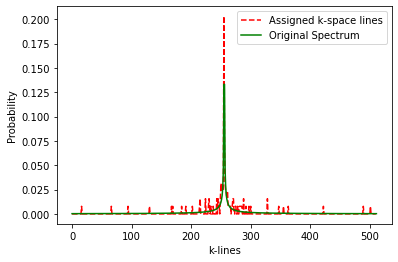

[ 16  66  94 130 167 169 184 191 202 214 215 224 229 230 231 233 237 243
 245 246 247 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 268 269 270 271 274 275 278 281 282 283 284 285 288 292 297
 300 328 347 355 363 422 489 501]
62


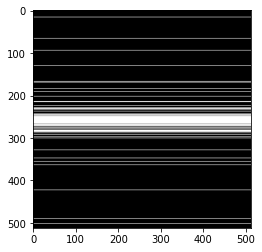

In [19]:
import numpy.random as ra

# Perform pseudo-random sampling:
# Draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = (int)(img_size / 4)
# Sample a uniform distribution
samples = ra.uniform(0, 1, nb_samples)
# For every sample
# find whether cdf_pdcay is equals the minimal value from the cumulative sum minus the sampled data is greater than 0
# Generate the kspace_lines accordingly
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]

# shift the samples lines by half of the k-space (i.e. image size as we're on Cartesian ref)
gen_klinesb = ((np.array(gen_klines) - 1)).astype(int) + (int)(img_size / 2)
print(gen_klinesb)

times = np.arange(1, img_size)
# calculate bins
lc = np.bincount(gen_klinesb, minlength=len(times))

# The distribution on kspace-lines
plt.figure()
plot1, =plt.plot(lc / float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, =plt.plot(p_decay, 'g', label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()

sampled_klines = np.array(np.unique(gen_klinesb))
print(sampled_klines)

nblines = np.size(sampled_klines)
print(nblines)
threshold = 2. * p_decay.min()
kspace_mask = np.zeros((img_size, img_size), dtype="float64")
kspace_mask[sampled_klines, :] = np.ones((nblines, img_size), dtype="float64")

plt.figure()
plt.imshow(kspace_mask, cmap='Greys_r')
plt.show()

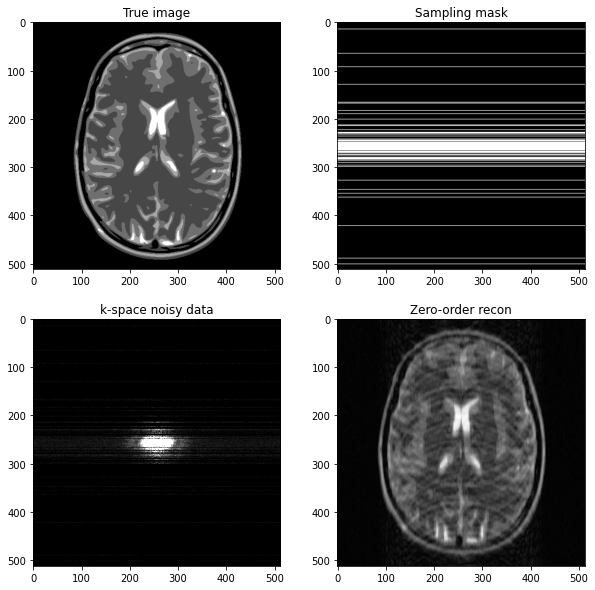

In [20]:
# Generate the kspace data
kspace_data = fftshift(fft(mri_img))
# add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask

# zero order solution
img_rec0 = ifft(ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask, cmap='Greys_r')
axs[0, 1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
# axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

## Cartesian periodic under-sampling along parallel lines

The goal here is to illustrate the typical artifacts of standard **deterministic regular** (or **periodic**) undersampling along the phase encoding direction (here $k_y$) used in parallel imaging. Below we illustrate the following cases:

1. Full Cartesian sampling $R = n/m = 1$ where $n = N^2$ is the image size, $N$ the image dimension and $m$ the number of measurements in kspace.
2. Undersampling with a factor $R=2, 4, \mathrm{or}\ 8$

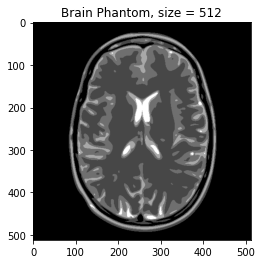

In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, filters

dirimg_2d = './data/'
img_size = 512
FOV = 0.2
pixelSize = FOV / img_size

filename = "BrainPhantom%s.png"%img_size
mri_img = io.imread(dirimg_2d + filename)
plt.figure()
plt.title("Brain Phantom, size = %s"%img_size)
plt.imshow(mri_img, cmap="Greys_r")

Text(0.5, 1.0, 'Cartesian recon')

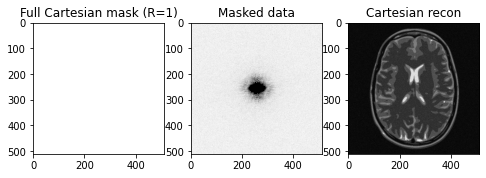

In [22]:
# No mask at all
kspace_mask_full = np.ones((img_size, img_size), dtype="float64")

# Generate the subsampled kspace with R=2
kspace_data = fftshift(fft(mri_img)) # put the 0-freq in the middle of axes 
# add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1 + 1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask_full

image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(1, 3, figsize=(8, 8) )
axs[0].imshow(kspace_mask_full, cmap='gray_r')
axs[0].set_title("Full Cartesian mask (R=1)")
axs[1].imshow(np.abs(kspace_data),  cmap='gray_r', vmax=.01*np.abs(kspace_data).max())
axs[1].set_title("Masked data")
axs[2].imshow(np.abs(image_rec0), cmap='gray')
axs[2].set_title("Cartesian recon")

Text(0.5, 1.0, 'Cartesian regular under-sampling mask (R=8)')

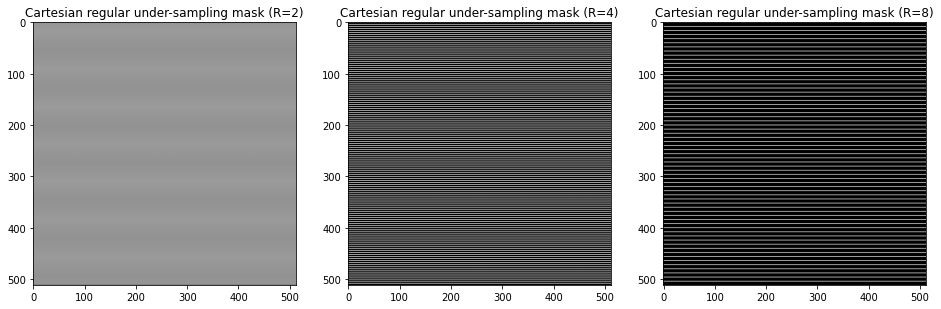

In [23]:
import numpy.matlib as mlib

# Generate Cartesian lines in a straghtforward manner
r2 = (int)(img_size/2)
r4 = (int)(img_size/4)
r8 = (int)(img_size/8)

selected_ksp_line = np.ones((1, img_size), dtype="float64")
skipped_ksp_line = np.zeros((1, img_size), dtype="float64")

k_space_pattern_r2 = np.concatenate((selected_ksp_line, skipped_ksp_line), axis=0)
kspace_mask_r2 = np.tile(k_space_pattern_r2, (r2, 1))

k_space_pattern_r4 = np.concatenate((selected_ksp_line, np.tile(skipped_ksp_line, (3, 1))), axis=0)
kspace_mask_r4 = np.tile(k_space_pattern_r4, (r4, 1))

k_space_pattern_r8 = np.concatenate((selected_ksp_line, np.tile(skipped_ksp_line, (7, 1))), axis=0)
kspace_mask_r8 = np.tile(k_space_pattern_r8, (r8, 1))

fig, axs = plt.subplots(1, 3, figsize=(16, 16) )
axs[0].imshow(kspace_mask_r2, cmap='Greys_r')
axs[0].set_title("Cartesian regular under-sampling mask (R=2)")
axs[1].imshow(kspace_mask_r4, cmap='Greys_r')
axs[1].set_title("Cartesian regular under-sampling mask (R=4)")
axs[2].imshow(kspace_mask_r8, cmap='Greys_r')
axs[2].set_title("Cartesian regular under-sampling mask (R=8)")

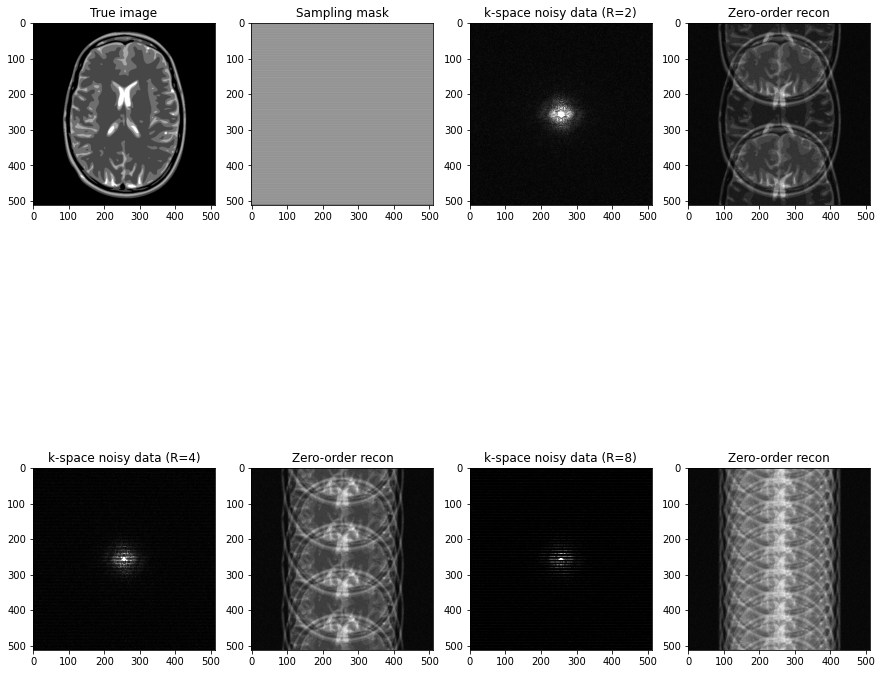

In [24]:
# Generate the kspace data: first Fourier transform the image
kspace_data_r2 = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data_r2 += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data_r2 *= kspace_mask_r2

# Zero order image reconstruction
image_rec0_r2 = ifft(np.fft.ifftshift(kspace_data_r2))

fig, axs = plt.subplots(2, 4, figsize=(15, 15) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask_r2, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[0,2].imshow(np.abs(kspace_data_r2),  cmap='gray', vmax=0.01*np.abs(kspace_data_r2).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[0,2].set_title("k-space noisy data (R=2)")
axs[0,3].imshow(np.abs(image_rec0_r2), cmap='gray')
axs[0,3].set_title("Zero-order recon")

kspace_data_r4 = np.fft.fftshift(fft(mri_img))
kspace_data_r4 += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data_r4 *= kspace_mask_r4

# Zero order image reconstruction
image_rec0_r4 = ifft(np.fft.ifftshift(kspace_data_r4))

axs[1,0].imshow(np.abs(kspace_data_r4),  cmap='gray', vmax=0.01*np.abs(kspace_data_r4).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (R=4)")
axs[1,1].imshow(np.abs(image_rec0_r4), cmap='gray')
axs[1,1].set_title("Zero-order recon")

kspace_data_r8 = np.fft.fftshift(fft(mri_img))
kspace_data_r8 += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data_r8 *= kspace_mask_r8

# Zero order image reconstruction
image_rec0_r8 = ifft(np.fft.ifftshift(kspace_data_r8))

axs[1,2].imshow(np.abs(kspace_data_r8),  cmap='gray', vmax=0.01*np.abs(kspace_data_r4).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,2].set_title("k-space noisy data (R=8)")
axs[1,3].imshow(np.abs(image_rec0_r8), cmap='gray')
axs[1,3].set_title("Zero-order recon")
plt.show()

## Non-Cartesian radial undersampling

You can play with the design parameters to regenerate different radial in-out patterns (so, we draw radial spokes over a rotating angle of $pi$). You can play with the number of shots by changing the under-sampling factor.

/home/s2287251/RDS/miniconda/envs/dev/lib/python3.9/site-packages/pysap_mri-0.4.0-py3.9.egg/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
/home/s2287251/RDS/miniconda/envs/dev/lib/python3.9/site-packages/pysap_mri-0.4.0-py3.9.egg/mri/operators/fourier/non_cartesian.py:35: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
/home/s2287251/RDS/miniconda/envs/dev/lib/python3.9/site-packages/pysap_mri-0.4.0-py3.9.egg/mri/operators/linear/dictionary.py:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/s2287251/RDS/miniconda/envs/dev/lib/python3.9/site-packages/pysap_mri-0.4.0-py3.9.egg/mri/operators/linear/dictionary.py:57: SyntaxWarning: "is" with a literal. Did you mean "=="?


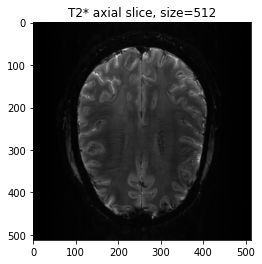

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
from mri.operators import NonCartesianFFT
from mri.operators.utils import convert_locations_to_mask, gridded_inverse_fourier_transform_nd
from pysap.data import get_sample_data
from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

mri_img = get_sample_data('2d-mri')
img_size = mri_img.shape[0]

plt.figure()
plt.title("T2* axial slice, size={}".format(img_size))

if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
    
plt.show()
    

In [6]:
# set up the first shot
import math

rfactor = 8
nb_shots = math.ceil(img_size / rfactor)

# vectorize the nb of shots
vec_shots = np.arange(0, nb_shots)

# define the regularly spaced samples on a single shot
nsamples = (np.arange(0, img_size) - img_size // 2) / (img_size)
print("number of samples per shot: {}".format(np.size(nsamples)))

shot_c = np.array(nsamples, dtype=np.complex_)
shots = np.array([], dtype=np.complex_)

# accumulate shots after rotating the initial one by the right angular increment
for k in vec_shots:
    shots = np.append(shots, shot_c * np.exp(2 * np.pi * 1j * k / (2* nb_shots)))

kspace_loc = np.zeros((len(shots), 2))

# assign real and imaginary parts of complex-valued k-space trajectories to k-space locations
kspace_loc[:, 0] = shots.real
kspace_loc[:, 1] = shots.imag
# plot full initialization 

number of samples per shot: 512


In [7]:
data = convert_locations_to_mask(kspace_loc, mri_img.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=mri_img.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(mri_img.data)

/home/s2287251/RDS/miniconda/envs/dev/lib/python3.9/site-packages/pysap_mri-0.4.0-py3.9.egg/mri/operators/fourier/utils/processing.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


NameError: name 'pynfft' is not defined